In [1]:
# Import the numpy library for matrix manipulations etc.
import numpy as np
import pandas as pd
import os
import sys
import cv2 as cv2

# Set up the graphics by importing the matplotlib plotting library
import matplotlib.pyplot as plt

import keras as kr
from keras.models import Sequential
from keras.layers import Dense

# Load data
from keras.datasets import fashion_mnist 
from keras.datasets import mnist 

(train_X,train_Y), (test_X,test_Y) = mnist.load_data()
#(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()

fashion_mnist_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

image_dim = 28

Using TensorFlow backend.


In [9]:
def display_image(image_array, clim=None):
    """ Show a single image with colorbar. Image given in 1D or 2D representation. """
    
    if len(image_array.shape) == 1:
        image_dim = int(np.sqrt(len(image_array)))
        img = np.reshape(image_array, [image_dim, image_dim])
    else:
        img = image_array
        
    plt.imshow(img, interpolation='nearest', cmap='binary')
    if clim is None:
        plt.clim([img.min(),img.max()])
    else:
        plt.clim(clim)
        
    plt.colorbar()
    plt.show()

    
def create_training_data(data_sets, labels = [], p_train = 0.8):
    """ Create training and testing datasets from a collection of data sets.
    
        Function shuffles the given data_sets.
    
        Parameters:
        -----------
        data_sets : list of numpy.ndarray
            List of data sets, where every set is assumed to have the same label.
        labels : numpy.array
            Labels for each data set. If not given, assume labels = range(len(data_sets))
        p_train : 0.8, float
            Fraction of data used for training. Rest is used for testing.
        
        
        Returns:
        --------
        (trainX, trainY), (testX, testY)
    """

    data_sets_len = []
    for data in data_sets:
        data_sets_len.append(len(data))

    if len(labels) != len(data_sets):
        labels = np.array(list(range(len(data_sets))))
        
    N_data_total  = sum(data_sets_len)
    N_data_train = int(p_train * N_data_total)
    N_data_test  = int((1 - p_train) * N_data_total)
               
    totalX = np.concatenate(data_sets, axis=0)
    totalY = [np.array([label]*size) for label, size in zip(labels, data_sets_len)]
    
    totalY = np.concatenate(totalY, axis=0)

    # Shuffle data.
    totalX_randidx = np.array(range(N_data_total))
    np.random.shuffle(totalX_randidx)

    totalX = totalX[totalX_randidx]
    totalY = totalY[totalX_randidx]

    # Split into trian and test sets.
    trainX = totalX[:N_data_train]
    testX  = totalX[N_data_train:]

    trainY = totalY[:N_data_train]
    testY  = totalY[N_data_train:]
    
    return (trainX, trainY), (testX, testY)


class NN_conv_classifier:
    "Aboutaleb class for loading and training a neural net with synthetic generated data sets."

    def __init__(self, trainX, trainY, testX, testY, layers=[], activationFunc='sigmoid', lossFunc = 'categorical_crossentropy', optimizer = 'adam'):

        self.trainX_size, self.image_dim_x, self.image_dim_y  = trainX.shape
        
        # Set images properties.
        self.trainX = np.expand_dims(train_X, 3)
        self.testX  = np.expand_dims(testX, 3)
        self.trainY = self.to_one_hot_encoding(trainY)
        self.testY  = self.to_one_hot_encoding(testY)
                
        # Set network properties.
        self.filter_size    = 5
        self.layers         = layers
        self.activationFunc = activationFunc
        self.lossFunc       = lossFunc
        self.optimizer      = optimizer
        
        # Build and train network.
        self.__build_network()
        self.__compile_network()
        
        # Nice names for numeric labels. (Set manually)
        self.shape_idx_to_name = dict(zip(np.unique(trainY), np.unique(trainY)))
        
    # Convert lablels to one-hot encoding.
    def to_one_hot_encoding(self, labels):   
        
        if len(labels.shape) == 2:
            return labels
        
        N_labels = len(np.unique(labels))

        train_Y_onehot = np.array([[0]*N_labels]*len(labels))
        for idx in range(len(train_Y_onehot)):
            train_Y_onehot[idx][labels[idx]] = 1
            
        return train_Y_onehot
        
    def __build_network(self):
        net=kr.models.Sequential()
        #net.add(kr.layers.Dense(self.layers[1], input_shape=(self.image_size,), activation=self.activationFunc))
        net.add(kr.layers.Conv2D(input_shape=(self.image_dim_x, self.image_dim_y, 1), filters=7, 
                                 kernel_size=[self.filter_size, self.filter_size], 
                                 activation=self.activationFunc, padding='same'))
        net.add(kr.layers.AveragePooling2D(pool_size=4))
        net.add(kr.layers.Flatten())
        net.add(kr.layers.Dense(10, activation='softmax'))
#         if(len(self.layers)>3):
#             for li in self.layers[2:-1]:
#                 net.add(kr.layers.Dense(li, activation=self.activationFunc))  
        self.net = net
            
    def __compile_network(self):
        self.net.compile(loss=self.lossFunc,
                         optimizer=self.optimizer,
                         metrics=['categorical_accuracy'])
            
    def train_network(self, batch_size=100, epochs=30):
        self.history = self.net.fit(self.trainX, self.trainY, batch_size=batch_size, epochs=epochs)
        
    def test_network(self):
        testX_probs    = self.net.predict_on_batch(self.testX)
        testX_max_prob = np.argmax(testX_probs, axis=1)
        accuracy       = sum((np.argmax(self.testY, axis=1) - testX_max_prob) == 0)/len(self.testY) 
        
        return accuracy
    
    def test_example(self):
        
        rand_idx     = np.random.randint(len(self.testX))
        image_sample = self.testX[rand_idx]
        shape_idx_to_name = self.testX[rand_idx]
        predict_prop = self.net.predict_on_batch(np.array([image_sample]))[0]
        predict_label = np.argmax(predict_prop)
        
        print('Label:', self.shape_idx_to_name[np.argmax(self.testY[rand_idx])], ', Prediction:', self.shape_idx_to_name[predict_label],\
              ', (prob=', predict_prop[predict_label] , ')')

        display_image(image_sample.squeeze())

In [3]:
NNtest = NN_conv_classifier(train_X, train_Y, test_X, test_Y, activationFunc='sigmoid')
NNtest.shape_idx_to_name = dict(zip(range(10), fashion_mnist_class_names))

In [4]:
NNtest.train_network(epochs=6)
NNtest.test_network()

Epoch 1/6
60000/60000 [==============================] - 83s 1ms/step - loss: 0.8604 - categorical_accuracy: 0.7249
Epoch 2/6
60000/60000 [==============================] - 69s 1ms/step - loss: 0.5231 - categorical_accuracy: 0.8173
Epoch 3/6
60000/60000 [==============================] - 68s 1ms/step - loss: 0.4558 - categorical_accuracy: 0.8395
Epoch 4/6
60000/60000 [==============================] - 79s 1ms/step - loss: 0.4200 - categorical_accuracy: 0.8520
Epoch 5/6
60000/60000 [==============================] - 77s 1ms/step - loss: 0.3958 - categorical_accuracy: 0.8612
Epoch 6/6
60000/60000 [==============================] - 71s 1ms/step - loss: 0.3805 - categorical_accuracy: 0.8657


0.8612

Label: T-shirt/top , Prediction: T-shirt/top , (prob= 0.709822 )


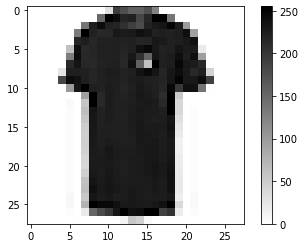

In [12]:
NNtest.test_example()

In [6]:
NNtest.net.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 7)         182       
_________________________________________________________________
average_pooling2d_1 (Average (None, 7, 7, 7)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 343)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3440      
Total params: 3,622
Trainable params: 3,622
Non-trainable params: 0
_________________________________________________________________


In [135]:
for weights in net_weights:
    print(weights.shape)

(5, 5, 1, 7)
(7,)
(343, 10)
(10,)


#### Visualize convolution kernels

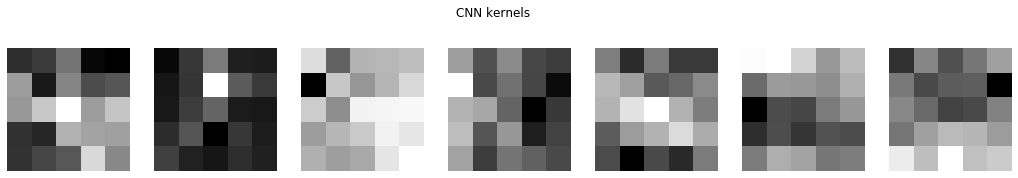

In [9]:
net_weights  = NNtest.net.get_weights()
conv_filters = net_weights[0].T.squeeze()

N_filter = len(conv_filters)

fig, axs = plt.subplots(1, N_filter, figsize = (18,3))
fig.suptitle('CNN kernels')

for idx, ax in enumerate(axs.flatten()):
    ax.imshow(conv_filters[idx], interpolation='nearest', cmap='binary')
    ax.axis('off')

## Encoding MNIST through the magnificent bottleneck

In [155]:
def create_mnist_squares(train_X, Nsamples = 100000, upsample=2):
    """ Merge MNSIT images to square of NxN images.    
    """
 
    Nimage, dim_x, dim_y = train_X.shape
    
    randint4 = np.random.randint(0, Nimage, upsample*upsample*Nsamples).reshape(-1, upsample*upsample)
    
    a      = train_X[randint4]
    aa     = a.reshape(-1, upsample, upsample*dim_x, dim_x)
    aamove = np.moveaxis(aa,1,2)
    aaa    = np.squeeze(aamove.reshape(-1,upsample*dim_x,1,upsample*dim_x))
    
    return aaa


class NN_MNIST_encoder:
    "Aboutaleb class for loading and training a neural net with synthetic generated data sets."

    def __init__(self, trainX, testX, layers=[], activationFunc='relu', lossFunc = 'mean_squared_error', optimizer = 'Adam'):

        self.trainX_size, self.image_dim_x, self.image_dim_y  = trainX.shape
        
        # Set images properties.
        self.trainX = np.expand_dims(trainX, 3)
        self.testX  = np.expand_dims(testX, 3)
                
        # Set network properties.
        self.filter_size    = 5
        self.Nconv_filer    = 20
        self.layers         = layers
        self.activationFunc = activationFunc
        self.lossFunc       = lossFunc
        self.optimizer      = optimizer
        
        # Build and train network.
        self.__build_network()
        self.__compile_network()
                        
    def __build_network(self):

        image_shape = (self.image_dim_x, self.image_dim_y, 1)
        kernel_size = (self.filter_size, self.filter_size)
        
        AveragePooling2D = kr.layers.AveragePooling2D
        UpSampling2D = kr.layers.UpSampling2D
        Conv2D = kr.layers.Conv2D
                
        autoenc = kr.models.Sequential()        
        
        autoenc.add(Conv2D(input_shape=image_shape, filters=self.Nconv_filer, kernel_size=self.filter_size,\
                           activation=self.activationFunc, padding='same'))
        autoenc.add(AveragePooling2D(pool_size=4))
        
        autoenc.add(Conv2D(filters=self.Nconv_filer, kernel_size=kernel_size, activation='relu', padding='same'))
        autoenc.add(AveragePooling2D(pool_size=4))
        
        autoenc.add(Conv2D(filters=self.Nconv_filer, kernel_size=[1,1], activation='relu', padding='same'))
        autoenc.add(UpSampling2D(size=4))
        
        autoenc.add(Conv2D(filters=self.Nconv_filer, kernel_size=kernel_size, activation='relu', padding='same'))
        autoenc.add(UpSampling2D(size=4))
        
        autoenc.add(Conv2D(filters=1, kernel_size=self.filter_size, activation='linear', padding='same'))

        self.net = autoenc
            
    def __compile_network(self):
        self.net.compile(loss      = self.lossFunc,
                         optimizer = self.optimizer,
                         metrics   = ['accuracy'])
            
    def train_network(self, batch_size=100, epochs=30):
        self.history = self.net.fit(self.trainX, self.trainX, batch_size=batch_size, epochs=epochs)
        
    def test_network(self):
        testX_probs    = self.net.predict_on_batch(self.testX)
        testX_max_prob = np.argmax(testX_probs, axis=1)
        accuracy       = sum((np.argmax(self.testY, axis=1) - testX_max_prob) == 0)/len(self.testY) 
        
        return accuracy
    
    def test_example(self):
        
        rand_idx     = np.random.randint(len(self.testX))
        image_sample = self.testX[rand_idx]
        shape_idx_to_name = self.testX[rand_idx]
        predict_prop = self.net.predict_on_batch(np.array([image_sample]))[0]
        predict_label = np.argmax(predict_prop)
        
        print('Label:', self.shape_idx_to_name[np.argmax(self.testY[rand_idx])], ', Prediction:', self.shape_idx_to_name[predict_label],\
              ', (prob=', predict_prop[predict_label] , ')')

        display_image(image_sample.squeeze())

In [182]:
train_X_sq = np.pad(train_X, [(0,0), (2,2),(2,2)])
test_X_sq = np.pad(test_X, [(0,0), (2,2),(2,2)])

#train_X_sq = create_mnist_squares(train_X, 100000, 2)
#test_X_sq  = create_mnist_squares(test_X,   20000, 2)

In [183]:
encode = NN_MNIST_encoder(train_X_sq, test_X_sq)

In [184]:
encode.net.summary()

for weights in encode.net.weights:
    print(weights.shape)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 32, 32, 20)        520       
_________________________________________________________________
average_pooling2d_19 (Averag (None, 8, 8, 20)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 8, 8, 20)          10020     
_________________________________________________________________
average_pooling2d_20 (Averag (None, 2, 2, 20)          0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 2, 2, 20)          420       
_________________________________________________________________
up_sampling2d_15 (UpSampling (None, 8, 8, 20)          0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 8, 8, 20)        

In [185]:
encode.train_network()

(60000, 32, 32, 1)
Epoch 1/30
60000/60000 [==============================] - 141s 2ms/step - loss: 2240.4233 - accuracy: 0.0853
Epoch 2/30
60000/60000 [==============================] - 152s 3ms/step - loss: 1572.9193 - accuracy: 0.2058
Epoch 3/30
60000/60000 [==============================] - 147s 2ms/step - loss: 1401.7963 - accuracy: 0.2282
Epoch 4/30
60000/60000 [==============================] - 153s 3ms/step - loss: 1305.2939 - accuracy: 0.2373
Epoch 5/30
60000/60000 [==============================] - 120s 2ms/step - loss: 1244.0632 - accuracy: 0.2435
Epoch 6/30
60000/60000 [==============================] - 122s 2ms/step - loss: 1199.1654 - accuracy: 0.2494
Epoch 7/30
60000/60000 [==============================] - 123s 2ms/step - loss: 1162.7269 - accuracy: 0.2558
Epoch 8/30
60000/60000 [==============================] - 135s 2ms/step - loss: 1136.9157 - accuracy: 0.2602
Epoch 9/30
60000/60000 [==============================] - 137s 2ms/step - loss: 1115.2910 - accuracy: 0.2645


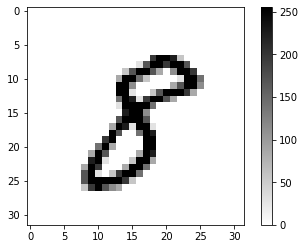

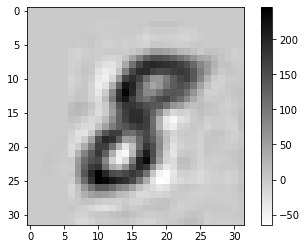

In [189]:
rnd_idx = np.random.randint(len(test_X_sq))

test_img = test_X_sq[rnd_idx]
test_img_ext = np.expand_dims([test_img], 3)
display_image(test_img)
a = encode.net.predict_on_batch(test_img_ext)
display_image(a.squeeze())

In [ ]:
extractor = kr.Model(inputs=encode.net.inputs,
                     outputs=[layer.output for layer in encode.net.layers])
features  = extractor(test_X_sq)

In [176]:
encode.net.inputs

[<tf.Tensor 'conv2d_37_input:0' shape=(None, 32, 32, 1) dtype=float32>]

In [190]:
def display_filters(which_layer):
    global BigImage
    
    the_layers=net.layers
    filters=the_layers[which_layer].get_weights()[0]
    s=shape(filters)
    MX=s[0]
    MY=s[1]
    num_in=s[2] # number of input channels
    num_out=s[3] # number of output channels
    BigImage=zeros([num_in*(MX+1),num_out*(MY+1)])
    BigImage[:,:]=1.0
    for j_in in range(num_in):
        for j_out in range(num_out):
            BigImage[j_in*(MX+1):(j_in+1)*(MX+1)-1,j_out*(MY+1):(j_out+1)*(MY+1)-1]=rescale_image(filters[:,:,j_in,j_out])
    plt.imshow(BigImage,origin='lower',interpolation='nearest',cmap='binary')
    plt.axis('off')
    plt.show()